<a href="https://colab.research.google.com/github/AlbertCoding42/ML-Projects/blob/main/MillingMachines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this project I've obtained data on milling machines and have managed to train an AI which predicts machine failures with an f1-score of 0.78.

### Target variable for this project will be conveniently labelled "Target" and is a boolean for when a machine has failed.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

file_path = '/content/milling_machine_data.xlsx'

# Load the data from the Excel file
data = pd.read_excel(file_path)

# Print the first few rows to check that the data was loaded correctly
data.head()

,UDI,Product_ID,Type,Air_temperature_[K],Process_temperature_[K],Rotational_speed_[rpm],Torque_[Nm],Tool_wear_[min],Target,Failure_Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



### **EDA and Preprocessing:**

In [ ]:
# Check for missing values in the dataset
print(data.isnull().sum())


UDI                        0
Product_ID                 0
Type                       0
Air_temperature_[K]        0
Process_temperature_[K]    0
Rotational_speed_[rpm]     0
Torque_[Nm]                0
Tool_wear_[min]            0
Target                     0
Failure_Type               0
dtype: int64


Failure_Type  Heat Dissipation Failure  No Failure  Overstrain Failure  \
Target                                                                   
0                                    0        9643                   0   
1                                  112           9                  78   

Failure_Type  Power Failure  Random Failures  Tool Wear Failure  
Target                                                           
0                         0               18                  0  
1                        95                0                 45  


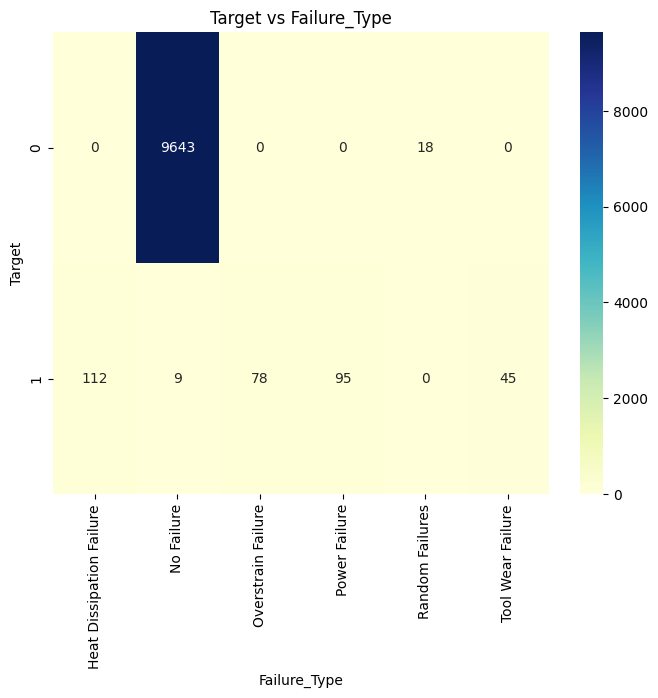

In [ ]:
# Create a cross-tabulation between 'Target' and 'Failure_Type'
cross_table = pd.crosstab(data['Target'], data['Failure_Type'])

# Print the cross-tabulation table
print(cross_table)

# Plot the cross-tabulation table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Target vs Failure_Type')
plt.xlabel('Failure_Type')
plt.ylabel('Target')
plt.show()


## From the tables we can see that the Target Variable is being used as a boolean for when the machine fails.
### However, it doesn't correlate to the Failure_Type variable perfectly, there are two inconsistencies:
### 1) The Random Failures are being recorded with Target 0
### 2) 9 machines which didn't fail have been recorded with Target 1

### To deal with the first issue I'll relabel each Random Failure to have Target 1:

In [ ]:
# Relabel "Random Failures" to have "Target" equal to 1
data.loc[data['Failure_Type'] == 'Random Failures', 'Target'] = 1

# Verify the changes
print(data[data['Failure_Type'] == 'Random Failures'][['Failure_Type', 'Target']])

# Save the updated DataFrame if needed
# data.to_excel('/content/milling_machine_data_updated.xlsx', index=False)


         Failure_Type  Target
1221  Random Failures       1
1302  Random Failures       1
1748  Random Failures       1
2072  Random Failures       1
2559  Random Failures       1
3065  Random Failures       1
3452  Random Failures       1
5471  Random Failures       1
5489  Random Failures       1
5495  Random Failures       1
5509  Random Failures       1
5553  Random Failures       1
5639  Random Failures       1
6091  Random Failures       1
6913  Random Failures       1
6960  Random Failures       1
7488  Random Failures       1
7868  Random Failures       1


### To deal with the second issue I'll delete these "No Failure" entries:

In [ ]:
# Filter and delete rows with "No Failure" and "Target" equal to 1
rows_to_delete = (data['Failure_Type'] == 'No Failure') & (data['Target'] == 1)
data = data[~rows_to_delete]

### Now lets verify these changes:

In [ ]:
cross_table = pd.crosstab(data['Target'], data['Failure_Type'])
print(cross_table)

Failure_Type  Heat Dissipation Failure  No Failure  Overstrain Failure  \
Target                                                                   
0                                    0        9643                   0   
1                                  112           0                  78   

Failure_Type  Power Failure  Random Failures  Tool Wear Failure  
Target                                                           
0                         0                0                  0  
1                        95               18                 45  


### Now I will test 4 different models: XGBoost, Random Forest, Decison Tree, LightGBM:

### Since  XGBoost and LightGBM require numeric data I will have to deal with non-numeric (categorical) columns in my dataset, such as "Product_ID", "Type", and "Failure_Type". I will one-hot encode "Product_ID" and "Type" and there will be no need to use Failure_Type since I am not interested in specific types of failures so this variable will not be included in the feature set.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# Preprocessing: One-hot encode only 'Product_ID' and 'Type'
data = pd.get_dummies(data, columns=['Product_ID', 'Type'], drop_first=True)

# Remove any special characters from column names (e.g., [, ], <)
data.columns = ["".join(c if c.isalnum() else "_" for c in str(col)) for col in data.columns]

# Split the data into features (X) and target (y)
X = data.drop(['Target', 'Failure_Type'], axis=1)  # Exclude 'Failure_Type' from features
y = data['Target']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

# Train and test each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Generate the classification report
    report = classification_report(y_test, y_pred)

    # Print the classification report for each model
    print(f"Classification Report for {model_name}:")
    print(report)
    print("----------------------------------")



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1920
           1       0.85      0.72      0.78        79

    accuracy                           0.98      1999
   macro avg       0.92      0.86      0.89      1999
weighted avg       0.98      0.98      0.98      1999

----------------------------------
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1920
           1       0.89      0.30      0.45        79

    accuracy                           0.97      1999
   macro avg       0.93      0.65      0.72      1999
weighted avg       0.97      0.97      0.96      1999

----------------------------------
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1920
           1       0.84      0.65      0.73       

### XGBoost has the best f1-score for predicting when Target will have the value 1 and therefore is the best at predicting if a machine will fail.
### I will now balance the data to improve performance. I will compare three different methods to balance the data: SMOTE (Synthetic Minority Over-sampling Technique), class weight balancing, and stratified sampling: (Note: I will also test LightGBM since it had an f1-score of 0.77)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from collections import Counter

# Method 1: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Method 2: Class Weight Balancing
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
model_weight_balanced = lgb.LGBMClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})

# Method 3: Stratified Sampling
model_stratified = lgb.LGBMClassifier()

# Train and test each model
models = {
    'XGBoost (Original)': XGBClassifier(),
    'XGBoost (SMOTE)': XGBClassifier(),
    'XGBoost (Class Weight Balancing)': model_weight_balanced,
    'XGBoost (Stratified Sampling)': model_stratified,
    'LightGBM (Original)': lgb.LGBMClassifier(),
    'LightGBM (SMOTE)': lgb.LGBMClassifier(),
    'LightGBM (Class Weight Balancing)': lgb.LGBMClassifier(class_weight={0: class_weights[0], 1: class_weights[1]}),
    'LightGBM (Stratified Sampling)': lgb.LGBMClassifier(),
}

for model_name, model in models.items():
    if 'XGBoost' in model_name:
        if 'SMOTE' in model_name:
            model.fit(X_train_smote, y_train_smote)
        else:
            model.fit(X_train, y_train)
    else:  # LightGBM models
        if 'SMOTE' in model_name:
            model.fit(X_train_smote, y_train_smote)
        else:
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    y_pred = model.predict(X_test)

    # Generate the classification report
    report = classification_report(y_test, y_pred)

    # Print the classification report for each model
    print(f"Classification Report for {model_name}:")
    print(report)
    print("----------------------------------")


Classification Report for XGBoost (Original):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1920
           1       0.85      0.72      0.78        79

    accuracy                           0.98      1999
   macro avg       0.92      0.86      0.89      1999
weighted avg       0.98      0.98      0.98      1999

----------------------------------
Classification Report for XGBoost (SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1920
           1       0.61      0.78      0.69        79

    accuracy                           0.97      1999
   macro avg       0.80      0.88      0.84      1999
weighted avg       0.98      0.97      0.97      1999

----------------------------------
Classification Report for XGBoost (Class Weight Balancing):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1920
           1      

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Classification Report for LightGBM (Original):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1920
           1       0.89      0.68      0.77        79

    accuracy                           0.98      1999
   macro avg       0.94      0.84      0.88      1999
weighted avg       0.98      0.98      0.98      1999

----------------------------------
Classification Report for LightGBM (SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1920
           1       0.52      0.82      0.63        79

    accuracy                           0.96      1999
   macro avg       0.75      0.90      0.81      1999
weighted avg       0.97      0.96      0.97      1999

----------------------------------


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Classification Report for LightGBM (Class Weight Balancing):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1920
           1       0.66      0.82      0.73        79

    accuracy                           0.98      1999
   macro avg       0.83      0.90      0.86      1999
weighted avg       0.98      0.98      0.98      1999

----------------------------------


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Classification Report for LightGBM (Stratified Sampling):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1920
           1       0.89      0.68      0.77        79

    accuracy                           0.98      1999
   macro avg       0.94      0.84      0.88      1999
weighted avg       0.98      0.98      0.98      1999

----------------------------------


### From the classification reports we can see XGBoost without data balancing performs best (f1-score of 0.78).